In [1]:
#Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

DATASET

In [2]:
#Load Dataset
dataset = pd.read_csv('./iris.csv')
dataset.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [3]:
#Overview of Dataset Characteristics
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [4]:
#Summary of N/A Values
dataset.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

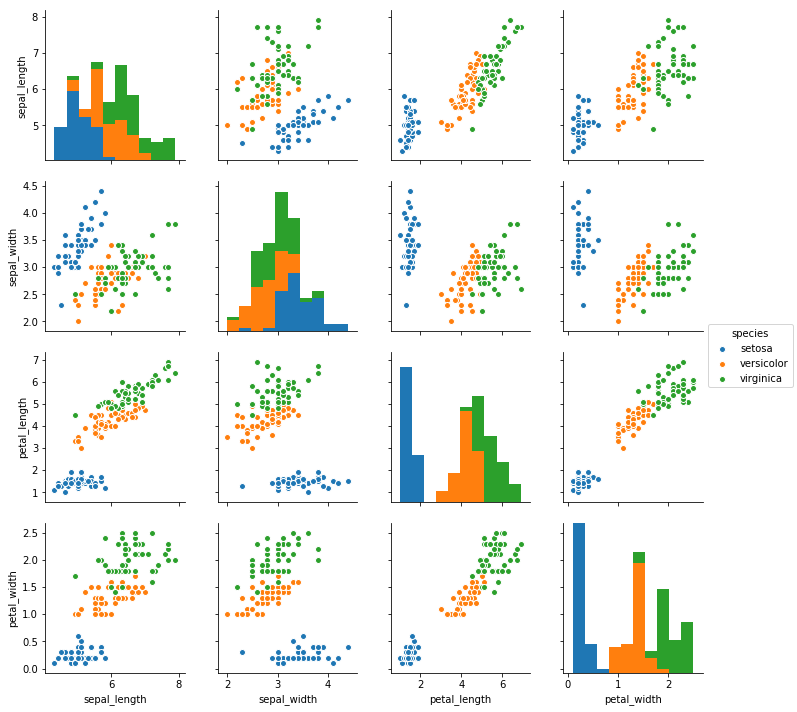

In [5]:
#Visualization of All Variables
pairplot = sns.pairplot(dataset, hue="species")
pairplot

In [6]:
#Review Correlation Between Variables
dataset.corr()

sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000

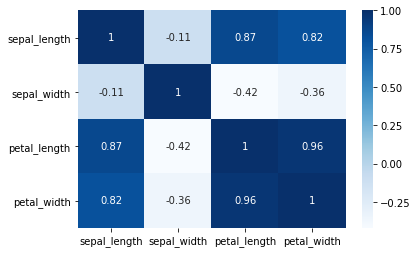

In [7]:
#Visualization of Correlations
import seaborn as sns
sns.heatmap(dataset.corr(),annot=True, cmap="Blues")

In [8]:
#Identify Correlated Columns
def correlation(dataset,threshold):
    col_corr = set() #set will contain unique values
    corr_matrix = dataset.corr() #Finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold: #checking correlation between columns
                colName = corr_matrix.columns[i] #Getting column name
                col_corr.add(colName) #Adding correlated column name higher than threshold value
                
    return col_corr #Returning set of column names

col=correlation(dataset.drop('species',axis=1),0.8)
print('Correlated Columns:',col)

Correlated Columns: {'petal_length', 'petal_width'}


In [9]:
#Create X and y variables
X = dataset.drop('species',axis=1).values
y = dataset['species'].values

In [10]:
#Scale X Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_2 = sc.fit_transform(X)

In [11]:
#Load Library for Training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X,y,test_size = 0.2, stratify = y, random_state = 100)

BUILD DECISION TREE MODEL

In [12]:
#Import Model
from sklearn.tree import DecisionTreeClassifier

#Construct Some Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_dt = Pipeline([('scl', StandardScaler()),
                   ('clf', DecisionTreeClassifier(random_state = 100))])

PLOT LEARNING CURVE

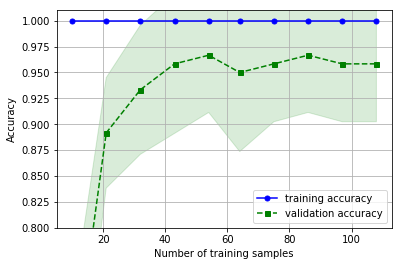

In [13]:
#Define Plot for Learning Curve
from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                                           X = X_train,
                                                           y = y_train,
                                                           cv = 10,
                                                           train_sizes = np.linspace(.1,1,10),
                                                           scoring='accuracy',
                                                           n_jobs = 1)
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)
    
    plt.plot(train_sizes, train_mean, color = 'blue', marker ='o', markersize = 5, label = 'training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
    
    plt.plot(train_sizes, test_mean, color = 'green', linestyle = '--', marker = 's', markersize = 5, label = 'validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')
    
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8,1.01])
    plt.show()
    
#Plot Learning Curve
plot_learning_curves(pipe_dt)

GRID SEARCH WITH NESTED CV

In [14]:
#Create table to compare MLA Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_colwidth', -1)

In [15]:
#Set Grid Search Params
max_depth = range(1,100)
param_griddt = {'clf__criterion':['gini','entropy'],
               'clf__max_depth':max_depth}

In [16]:
#Optimize Model
cv2 = RepeatedKFold (n_splits = 10, n_repeats = 5, random_state = 100)
opt_dt = GridSearchCV(estimator = pipe_dt, param_grid = param_griddt,
                     cv = cv2, verbose = 0, scoring = 'accuracy', n_jobs = -1)

In [17]:
#List of Pipelines for ease of iteration
grids = [opt_dt]

In [18]:
#Dictionary of Pipelines and Classifier Types for Ease of Reference
grid_dict = {0:'dt'}

In [19]:
#Create Dataframe for MLA Analysis
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for idx, gs in enumerate(grids):
    
    #Fit Grid Search
    gs.fit(X_train, y_train)
    
    #Nested CV
    scoresNestedPre = cross_val_score(gs, X_2, y,
                                     scoring = 'precision_weighted', cv = 5,
                                     n_jobs = -1)
    scoresNestedRec = cross_val_score(gs, X_2, y, scoring = 'recall_weighted', cv = 5,
                                     n_jobs = -1)
    
    #Create Dataframe to Compare Models
    MLA_compare.loc[row_index, 'Algorithm Name'] = grid_dict[idx]
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(gs.best_score_, 2)
    MLA_compare.loc[row_index, 'Precision-NestedCV'] = '{:0.2f} +/- {:0.2f}'.format(np.mean(scoresNestedPre), 
                                                                                    np.std(scoresNestedPre))
    MLA_compare.loc[row_index, 'Recall-NestedCV'] = '{:0.2f} +/- {:0.2f}'.format(np.mean(scoresNestedRec), 
                                                                                    np.std(scoresNestedRec))
    MLA_compare.loc[row_index, 'MLA_Paramaters'] = str(gs.best_params_)
    row_index += 1
    
MLA_compare.sort_values (by = ['Precision-NestedCV'], ascending = False, inplace = True)
MLA_compare

Algorithm Name  Train Accuracy Precision-NestedCV Recall-NestedCV  \
0  dt             0.96            0.96 +/- 0.02      0.96 +/- 0.02    

                                    MLA_Paramaters  
0  {'clf__criterion': 'gini', 'clf__max_depth': 2}

FEATURE IMPORTANCE

In [20]:
#Feature Importance - optimized
for name, score in zip(list(dataset), opt_dt.best_estimator_.named_steps['clf'].feature_importances_):
    print(name, round(score,2))

sepal_length 0.0
sepal_width 0.0
petal_length 0.54
petal_width 0.46
